In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ldpc import BpOsdDecoder
import pymatching
from rotated_surface_code import RotatedSurfaceCode
from decoder import BPDecoder, RelayBPDecoder
from monte_carlo_utils import sample_error_and_syndrome, get_logical_error_rate, print_statistics

# Test implementation of rotated surface code

In [2]:
code = RotatedSurfaceCode(5)

In [3]:
# Check the index-to-coodinate and coordinate-to-index mappings of the data qubits and stabilizers
for j in range(code.n):
    row, col = code._dq_to_coord(j)
    assert code._coord_to_dq(row, col) == j
    print("Data qubit {} has coordinates ({}, {}).".format(j, row, col))

for i in range(code.mx):
    row, col = code._xstab_to_coord(i)
    assert code._coord_to_xstab(row, col) == i
    print("X-type stabilizer {} has coordinates ({}, {}).".format(i, row, col))

for i in range(code.mz):
    row, col = code._zstab_to_coord(i)
    assert code._coord_to_zstab(row, col) == i
    print("Z-type stabilizer {} has coordinates ({}, {}).".format(i, row, col))

Data qubit 0 has coordinates (1, 1).
Data qubit 1 has coordinates (1, 3).
Data qubit 2 has coordinates (1, 5).
Data qubit 3 has coordinates (1, 7).
Data qubit 4 has coordinates (1, 9).
Data qubit 5 has coordinates (3, 1).
Data qubit 6 has coordinates (3, 3).
Data qubit 7 has coordinates (3, 5).
Data qubit 8 has coordinates (3, 7).
Data qubit 9 has coordinates (3, 9).
Data qubit 10 has coordinates (5, 1).
Data qubit 11 has coordinates (5, 3).
Data qubit 12 has coordinates (5, 5).
Data qubit 13 has coordinates (5, 7).
Data qubit 14 has coordinates (5, 9).
Data qubit 15 has coordinates (7, 1).
Data qubit 16 has coordinates (7, 3).
Data qubit 17 has coordinates (7, 5).
Data qubit 18 has coordinates (7, 7).
Data qubit 19 has coordinates (7, 9).
Data qubit 20 has coordinates (9, 1).
Data qubit 21 has coordinates (9, 3).
Data qubit 22 has coordinates (9, 5).
Data qubit 23 has coordinates (9, 7).
Data qubit 24 has coordinates (9, 9).
X-type stabilizer 0 has coordinates (0, 2).
X-type stabilize

In [4]:
# Check the stabilizer matrices
for i in range(code.mx):
    support = np.nonzero(code.Hx[i] == 1)[0]
    print("X-type stabilizer {} involves data qubits {}".format(i, support))

for i in range(code.mz):
    support = np.nonzero(code.Hz[i] == 1)[0]
    print("Z-type stabilizer {} involves data qubits {}".format(i, support))

X-type stabilizer 0 involves data qubits [0 1]
X-type stabilizer 1 involves data qubits [2 3]
X-type stabilizer 2 involves data qubits [1 2 6 7]
X-type stabilizer 3 involves data qubits [3 4 8 9]
X-type stabilizer 4 involves data qubits [ 5  6 10 11]
X-type stabilizer 5 involves data qubits [ 7  8 12 13]
X-type stabilizer 6 involves data qubits [11 12 16 17]
X-type stabilizer 7 involves data qubits [13 14 18 19]
X-type stabilizer 8 involves data qubits [15 16 20 21]
X-type stabilizer 9 involves data qubits [17 18 22 23]
X-type stabilizer 10 involves data qubits [21 22]
X-type stabilizer 11 involves data qubits [23 24]
Z-type stabilizer 0 involves data qubits [ 5 10]
Z-type stabilizer 1 involves data qubits [0 1 5 6]
Z-type stabilizer 2 involves data qubits [ 6  7 11 12]
Z-type stabilizer 3 involves data qubits [2 3 7 8]
Z-type stabilizer 4 involves data qubits [ 8  9 13 14]
Z-type stabilizer 5 involves data qubits [4 9]
Z-type stabilizer 6 involves data qubits [15 20]
Z-type stabilizer

In [5]:
# Check the logical operators
print("Logical X operator involves data qubits {}".format(np.nonzero(code.Lx[0] == 1)[0]))
print("Logical Z operator involves data qubits {}".format(np.nonzero(code.Lz[0] == 1)[0]))

Logical X operator involves data qubits [ 0  5 10 15 20]
Logical Z operator involves data qubits [0 1 2 3 4]


In [6]:
# Check the X-type check matrices and action matrices for the phenomenological error model with 3 rounds of stabilizer measurements
num_round = 3
cm, am, _, _ = code.get_check_matrices_and_action_matrices('phenomenological', num_round)

def from_detector_idx_to_spacetime_coord(detector_idx):
    t, space = divmod(detector_idx, code.mx)
    x, y = code._xstab_to_coord(space)
    return x, y, t

def from_error_idx_to_spacetime_coord(error_idx):
    if error_idx < num_round * code.n:
        t, space = divmod(error_idx, code.n)
        x, y = code._dq_to_coord(space)
    else:
        t, space = divmod(error_idx - num_round * code.n, code.mx)
        x, y = code._xstab_to_coord(space)
    return x, y, t

for i in range(cm.shape[0]):
    detector_spacetime = from_detector_idx_to_spacetime_coord(i)
    errors_index = np.nonzero(cm[i, :])[0].tolist()
    errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
    
    print("The X-type detector at spacetime location {} detects errors at spacetime locations {}".format(
        detector_spacetime, errors_spacetime))

errors_index = np.nonzero(am[0, :])[0].tolist()
errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
print("The logical X operator can be flipped by errors at spacetime locations {}".format(
    errors_spacetime))

The X-type detector at spacetime location (0, 2, 0) detects errors at spacetime locations [(1, 1, 0), (1, 3, 0), (0, 2, 0)]
The X-type detector at spacetime location (0, 6, 0) detects errors at spacetime locations [(1, 5, 0), (1, 7, 0), (0, 6, 0)]
The X-type detector at spacetime location (2, 4, 0) detects errors at spacetime locations [(1, 3, 0), (1, 5, 0), (3, 3, 0), (3, 5, 0), (2, 4, 0)]
The X-type detector at spacetime location (2, 8, 0) detects errors at spacetime locations [(1, 7, 0), (1, 9, 0), (3, 7, 0), (3, 9, 0), (2, 8, 0)]
The X-type detector at spacetime location (4, 2, 0) detects errors at spacetime locations [(3, 1, 0), (3, 3, 0), (5, 1, 0), (5, 3, 0), (4, 2, 0)]
The X-type detector at spacetime location (4, 6, 0) detects errors at spacetime locations [(3, 5, 0), (3, 7, 0), (5, 5, 0), (5, 7, 0), (4, 6, 0)]
The X-type detector at spacetime location (6, 4, 0) detects errors at spacetime locations [(5, 3, 0), (5, 5, 0), (7, 3, 0), (7, 5, 0), (6, 4, 0)]
The X-type detector at

In [7]:
# Check the Z-type check matrices and action matrices for the phenomenological error model with 3 rounds of stabilizer measurements
num_round = 3
_, _, cm, am = code.get_check_matrices_and_action_matrices('phenomenological', num_round)

def from_detector_idx_to_spacetime_coord(detector_idx):
    t, space = divmod(detector_idx, code.mz)
    x, y = code._zstab_to_coord(space)
    return x, y, t

def from_error_idx_to_spacetime_coord(error_idx):
    if error_idx < num_round * code.n:
        t, space = divmod(error_idx, code.n)
        x, y = code._dq_to_coord(space)
    else:
        t, space = divmod(error_idx - num_round * code.n, code.mz)
        x, y = code._zstab_to_coord(space)
    return x, y, t

for i in range(cm.shape[0]):
    detector_spacetime = from_detector_idx_to_spacetime_coord(i)
    errors_index = np.nonzero(cm[i, :])[0].tolist()
    errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
    
    print("The Z-type detector at spacetime location {} detects errors at spacetime locations {}".format(
        detector_spacetime, errors_spacetime))

errors_index = np.nonzero(am[0, :])[0].tolist()
errors_spacetime = [from_error_idx_to_spacetime_coord(j) for j in errors_index]
print("The logical Z operator can be flipped by errors at spacetime locations {}".format(
    errors_spacetime))

The Z-type detector at spacetime location (4, 0, 0) detects errors at spacetime locations [(3, 1, 0), (5, 1, 0), (4, 0, 0)]
The Z-type detector at spacetime location (2, 2, 0) detects errors at spacetime locations [(1, 1, 0), (1, 3, 0), (3, 1, 0), (3, 3, 0), (2, 2, 0)]
The Z-type detector at spacetime location (4, 4, 0) detects errors at spacetime locations [(3, 3, 0), (3, 5, 0), (5, 3, 0), (5, 5, 0), (4, 4, 0)]
The Z-type detector at spacetime location (2, 6, 0) detects errors at spacetime locations [(1, 5, 0), (1, 7, 0), (3, 5, 0), (3, 7, 0), (2, 6, 0)]
The Z-type detector at spacetime location (4, 8, 0) detects errors at spacetime locations [(3, 7, 0), (3, 9, 0), (5, 7, 0), (5, 9, 0), (4, 8, 0)]
The Z-type detector at spacetime location (2, 10, 0) detects errors at spacetime locations [(1, 9, 0), (3, 9, 0), (2, 10, 0)]
The Z-type detector at spacetime location (8, 0, 0) detects errors at spacetime locations [(7, 1, 0), (9, 1, 0), (8, 0, 0)]
The Z-type detector at spacetime location 

# Monte Carlo simulation under code-capacity noise model

#### MWPM decoder (from `ldpc` python package)

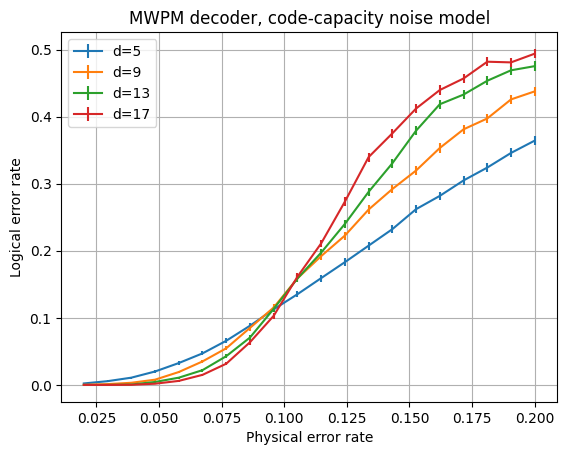

In [10]:
N = 5000

d_list = list(range(5, 18, 4))
p_list = np.linspace(0.02, 0.2, 20).tolist()
ler_array = np.zeros((len(d_list), len(p_list)))

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)
    # Get check matrix and action matrix. We focus on X-type stabilizers.
    cm, am, _, _ = code.get_check_matrices_and_action_matrices(noise_model='code-capacity')
    # Number of detectors and error mechanisms
    m = cm.shape[0]
    n = cm.shape[1]

    for j, p in enumerate(p_list):
        # Set error rate vector
        error_rate = np.ones(n, dtype=float) * p
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, error_rate, N, seed=42)
        # Construct decoder
        matching = pymatching.Matching.from_check_matrix(cm, weights=np.log((1 - error_rate) / error_rate))
        # Decode
        decoded_error = matching.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(p_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("MWPM decoder, code-capacity noise model")
plt.show()

BP decoder

In [9]:
# Construct decoder
decoder = BPDecoder(H=cm, prior=error_rate)
# Decode
decoded_error = decoder.decode_batch(syndrome)
# Show statistics
print_statistics(cm, am, true_error, decoded_error)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 190.24it/s]


Total number of samples:  100
Number of samples with incorrect syndrome: 57
Number of samples with correct syndrome but with logical error: 2
Decoding failure rate: 59.0%


Relay-BP decoder

In [10]:
# Set decoder parameters
num_sol=1
max_leg=301
max_iter_list = [80] + [60] * (max_leg - 1)
# Sample memory strength parameters
np.random.seed(0)
mem_strength = -0.25 + 0.85 / 2 * np.random.uniform(-1, 1, size=(max_leg, code.n))
mem_strength[0, :] = 0.35

# Construct decoder
decoder = RelayBPDecoder(
    H=cm,
    prior=error_rate,
    num_sol=num_sol,
    max_leg=max_leg,
    mem_strength=mem_strength,
    max_iter_list=max_iter_list
)
# Decode
decoded_error = decoder.decode_batch(syndrome)
# Show statistics
print_statistics(cm, am, true_error, decoded_error)

100%|██████████| 100/100 [00:11<00:00,  8.78it/s]

Total number of samples:  100
Number of samples with incorrect syndrome: 0
Number of samples with correct syndrome but with logical error: 7
Decoding failure rate: 7.000000000000001%


BP+OSD decoder (from `ldpc` python package)

In [11]:
# Construct decoder
decoder = BpOsdDecoder(
    pcm=cm,
    error_channel=error_rate.tolist(),
    bp_method='minimum_sum',
    max_iter=code.n,
    schedule='parallel', # 'serial'
    osd_method='osd_cs',
    osd_order=2
)
# Decode
decoded_error = np.zeros((N, cm.shape[1]), dtype=int)
for i in range(N):
    decoded_error[i] = decoder.decode(syndrome[i])
# Show statistics
print_statistics(cm, am, true_error, decoded_error)

Total number of samples:  100
Number of samples with incorrect syndrome: 0
Number of samples with correct syndrome but with logical error: 6
Decoding failure rate: 6.0%


# Monte Carlo simulation under phenomenological noise model

#### MWPM decoder (from `ldpc` python package)

d=5, p=0.02, ler=0.036
d=5, p=0.023333333333333334, ler=0.05366666666666667
d=5, p=0.02666666666666667, ler=0.07666666666666666
d=5, p=0.03, ler=0.09466666666666666
d=5, p=0.03333333333333333, ler=0.117
d=5, p=0.03666666666666667, ler=0.13633333333333333
d=5, p=0.04, ler=0.159
d=9, p=0.02, ler=0.019333333333333334
d=9, p=0.023333333333333334, ler=0.041666666666666664
d=9, p=0.02666666666666667, ler=0.06866666666666667
d=9, p=0.03, ler=0.102
d=9, p=0.03333333333333333, ler=0.14866666666666667
d=9, p=0.03666666666666667, ler=0.22333333333333333
d=9, p=0.04, ler=0.2776666666666667
d=13, p=0.02, ler=0.008333333333333333
d=13, p=0.023333333333333334, ler=0.02266666666666667
d=13, p=0.02666666666666667, ler=0.054
d=13, p=0.03, ler=0.11266666666666666
d=13, p=0.03333333333333333, ler=0.19266666666666668
d=13, p=0.03666666666666667, ler=0.271
d=13, p=0.04, ler=0.3443333333333333


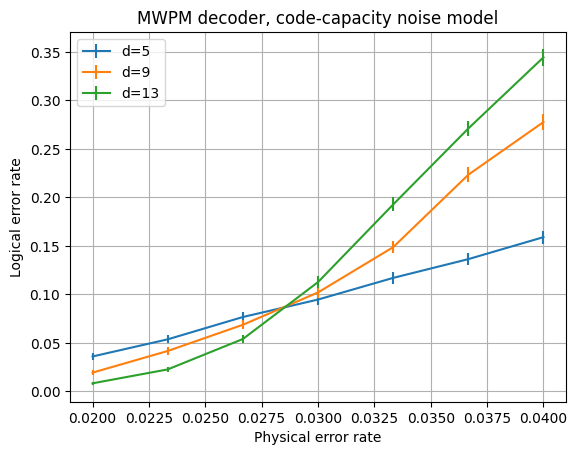

In [8]:
N = 3000

d_list = list(range(5, 14, 4))
p_list = np.linspace(0.02, 0.04, 7).tolist()
ler_array = np.zeros((len(d_list), len(p_list)))

for i, d in enumerate(d_list):
    # Construct the code
    code = RotatedSurfaceCode(d)
    # Get check matrix and action matrix. We focus on X-type stabilizers.
    cm, am, _, _ = code.get_check_matrices_and_action_matrices(noise_model='phenomenological', num_round=d)
    # Number of detectors and error mechanisms
    m = cm.shape[0]
    n = cm.shape[1]

    for j, p in enumerate(p_list):
        # Set error rate vector
        error_rate = np.ones(n, dtype=float) * p
        # Sample error patterns and calculate syndromes
        true_error, syndrome = sample_error_and_syndrome(cm, error_rate, N, seed=42)
        # Construct decoder
        matching = pymatching.Matching.from_check_matrix(cm, weights=np.log((1 - error_rate) / error_rate))
        # Decode
        decoded_error = matching.decode_batch(syndrome)
        # Calculate logical error rate
        ler = get_logical_error_rate(cm, am, true_error, decoded_error)
        # Store the result
        ler_array[i, j] = ler

        print(f"d={d}, p={p}, ler={ler}")

plt.figure()
for i, d in enumerate(d_list):
    ler = ler_array[i]
    std_err = (ler * (1 - ler) / N) ** 0.5
    plt.errorbar(p_list, ler, yerr=std_err, label="d={}".format(d))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.legend()
plt.title("MWPM decoder, code-capacity noise model")
plt.show()

BP+OSD decoder (from `ldpc` python package)

In [11]:
# Construct decoder
decoder = BpOsdDecoder(
    pcm=cm,
    error_channel=error_rate.tolist(),
    bp_method='minimum_sum',
    max_iter=cm.shape[1],
    schedule='parallel', # 'serial'
    osd_method='osd_cs',
    osd_order=2
)
# Decode
decoded_error = np.zeros((N, cm.shape[1]), dtype=int)
for i in tqdm(range(N)):
    decoded_error[i] = decoder.decode(syndrome[i])
# Show statistics
print_statistics(cm, am, true_error, decoded_error, num_round=num_round)

100%|██████████| 1000/1000 [00:31<00:00, 32.11it/s]


Total number of samples:  1000
Number of samples with incorrect syndrome: 0
Number of samples with correct syndrome but with logical error: 28
Decoding failure rate: 2.8000000000000003%
Logical error rate per cycle: 0.2578440508133828%


BP decoder

In [18]:
# Construct decoder
decoder = BPDecoder(H=cm, prior=error_rate)
# Decode
decoded_error = decoder.decode_batch(syndrome)
# Show statistics
print_statistics(cm, am, true_error, decoded_error)

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]

Total number of samples:  100
Number of samples with incorrect syndrome: 86
Number of samples with correct syndrome but with logical error: 0
Decoding failure rate: 86.0%


Relay-BP decoder

In [22]:
# Set decoder parameters
num_sol=1
max_leg=3
max_iter_list = [80] + [60] * (max_leg - 1)
# Sample memory strength parameters
np.random.seed(0)
mem_strength = -0.25 + 0.85 / 2 * np.random.uniform(-1, 1, size=(max_leg, cm.shape[1]))
mem_strength[0, :] = 0.35

# Construct decoder
decoder = RelayBPDecoder(
    H=cm,
    prior=error_rate,
    num_sol=num_sol,
    max_leg=max_leg,
    mem_strength=mem_strength,
    max_iter_list=max_iter_list
)
# Decode
decoded_error = decoder.decode_batch(syndrome)
# Show statistics
print_statistics(cm, am, true_error, decoded_error)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]

Total number of samples:  100
Number of samples with incorrect syndrome: 71
Number of samples with correct syndrome but with logical error: 6
Decoding failure rate: 77.0%


MWPM decoder (from `ldpc` python package)

In [ ]:
weights = np.log((1 - error_rate) / error_rate)
matching = pymatching.Matching.from_check_matrix(cm, weights=weights)
decoded_error = matching.decode_batch(syndrome)
print_statistics(cm, am, true_error, decoded_error, num_round=num_round)